In [26]:
'''
Windows: Open Anaconda prompt
conda create --name tigre_env -c anaconda -c ccpi -c conda-forge  python tigre simpleitk ipykernel opencv astropy tomopy nibabel scikit-image scikit-learn scipy tqdm scikit-learn-intelex jupyter ipywidgets
conda activate tigre_env

conda list --export > conda-package-list.txt
conda create -n tigre_env --file conda-package-list.txt
'''

import json
import math
import multiprocessing
import os
import sys
from __future__ import division


import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import tomopy
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from PIL import Image
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from skimage.registration import phase_cross_correlation
from tqdm import trange, tqdm
# from tqdm.notebook import tqdm as tqdm

import tigre
import tigre.algorithms as algs
from tigre.utilities.geometry import Geometry

import filereader

kernel = Gaussian2DKernel(x_stddev=2)

# make a list of globals for the recnstruction setting, and log them in a json file
gFillgap = True
gMedianfilter = False
gBadPixelCorrection = True
gReconVoxels = (600, 600, 600)  # number of voxels              (vx)
gReconSize = (15, 15, 15)      # total size of the image       (mm)
# gDistSourceDetect = 192.57   # Unused variable - this needs to be checked properly
# gDistSourceObject = 43.74    # Unused variable - this needs to be checked properly



class ConeGeometryJasper(Geometry):

    def __init__(self, high_quality=True, nVoxel = None):

        Geometry.__init__(self)
        if high_quality:
            # VARIABLE                                          DESCRIPTION                    UNITS
            # -------------------------------------------------------------------------------------
            self.DSD = 192.57                                      # Distance Source Detector      (mm)
            self.DSO = self.DSD-43.74                                       # Distance Source Origin        (mm)
            # Detector parameters
            self.nDetector = np.array((512, 512))               # number of pixels              (px)
            self.dDetector = np.array((0.055, 0.055))               # size of each pixel            (mm)
            self.sDetector = self.nDetector * self.dDetector    # total size of the detector    (mm)
            # Image parameters
            self.nVoxel = np.array((512, 512, 512))             # number of voxels              (vx)
            self.sVoxel = np.array((28.16, 28.16, 28.16))          # total size of the image       (mm)
            self.dVoxel = self.sVoxel/self.nVoxel               # size of each voxel            (mm)
            # Offsets
#             self.offOrigin = np.array((0,2.53,0))                # Offset of image from origin   (mm)
            self.offOrigin = np.array((0,0,0))                # Offset of image from origin   (mm)
            self.offDetector = np.array((0, 0))                 # Offset of Detector            (mm)
#             self.offDetector = np.array((0, -2.4684))                 # Offset of Detector            (mm)
            self.rotDetector = np.array((0,0,0))

            # Auxiliary
            self.accuracy = 0.5                                 # Accuracy of FWD proj          (vx/sample)
            # Mode
            self.mode = 'cone'                                  # parallel, cone                ...
            self.filter = None
        else:
            self.DSD = 192.57                                      # Distance Source Detector      (mm)
            self.DSO = self.DSD -  43.74                                       # Distance Source Origin        (mm)
            # Detector parameters
#             self.nDetector = np.array((256, 256))               # number of pixels              (px)
            self.nDetector = np.array((11, 512))               # number of pixels              (px)
            self.dDetector = np.array((0.055, 0.055))               # size of each pixel            (mm)
            self.sDetector = self.nDetector * self.dDetector    # total size of the detector    (mm)
            # Image parameters
            self.nVoxel = np.array((1, 512, 512))             # number of voxels              (vx)
            self.sVoxel = np.array((0.05, 25.6, 25.6))          # total size of the image       (mm)
            self.dVoxel = self.sVoxel/self.nVoxel               # size of each voxel            (mm)
            # Offsets
#             self.offOrigin = np.array((0,2.53,0))                # Offset of image from origin   (mm)
            self.offOrigin = np.array((0,0,0))                # Offset of image from origin   (mm)
            self.offDetector = np.array((0,0))                 # Offset of Detector            (mm)
            self.rotDetector = np.array((0,0,0))

            # Auxiliary
            self.accuracy = 0.5                                 # Accuracy of FWD proj          (vx/sample)
            # Mode
            self.mode = 'cone'                                  # parallel, cone                ...
            self.filter = None
        if nVoxel is not None:
            # VARIABLE                                          DESCRIPTION                    UNITS
            # -------------------------------------------------------------------------------------
            self.DSD = 1536                                     # Distance Source Detector      (mm)
            self.DSO = 1000                                     # Distance Source Origin        (mm)
                                                                # Detector parameters
            self.nDetector = np.array((nVoxel[1],
                                       nVoxel[2])
                                                                ) # (V,U) number of pixels        (px)
            self.dDetector = np.array([0.8, 0.8])               # size of each pixel            (mm)
            self.sDetector = self.dDetector * self.nDetector    # total size of the detector    (mm)
                                                                # Image parameters
            self.nVoxel = np.array((nVoxel))                    # number of voxels              (vx)
            self.sVoxel = np.array((256, 256, 256))             # total size of the image       (mm)
            self.dVoxel = self.sVoxel / self.nVoxel             # size of each voxel            (mm)
            # Offsets
            self.offOrigin = np.array((0, 0, 0))                # Offset of image from origin   (mm)
            self.offDetector = np.array((0, 0))                 # Offset of Detector            (mm)
            self.rotDetector = np.array((0, 0, 0))
            # Auxiliary
            self.accuracy = 0.5                                 # Accuracy of FWD proj          (vx/sample)
            # Mode
            self.mode = 'cone'                                  # parallel, cone


def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    pc[-1] -= y
    return np.roots(pc)


def find_optimal_offset(projections, angles, detector_x_offsets, detector_y_offsets, stageoffset=0, searchrange=70):
    ''' This function takes quite a while, which can probably be optimized.
    On the other hand, we only have to do this once per scan setup, and then store the value for later use.
    '''
    projection0 = projections[0, :, :]
    projection180 = np.flip(projections[round(projections.shape[0]/2)-1, :, :], 1)
    print(detector_x_offsets[0], detector_x_offsets[round(projections.shape[0]/2)-1])
    print(detector_y_offsets[0], detector_y_offsets[round(projections.shape[0]/2)-1])

    shift, error, diffphase = phase_cross_correlation(projection0, projection180,
                                                      upsample_factor=100)

    estimate = -shift.item(1)/2
    # print(estimate)
    # estimate = 2.18
    geosmall = ConeGeometryJasper(high_quality=False)
    # we should avoid pixels from the cross of the detector
    yshift = 3
    # we also need to take into account that detector motion up to 5 pixesl could have been used during the acquisition
    projections_small = projections[:, int(
        projections.shape[1]/2)-6-yshift:int(projections.shape[1]/2)+5-yshift, :]

    maxvalue = -9999
    opt_shift = -99
    cnt = 0
    xvalues = []
    yvalues = []
    for i in range(int(estimate*100)-searchrange, int(estimate*100)+searchrange, 1):
        # note that the detector x and y axis are opposite the x and y coordinate system of the geometry
        geosmall.offDetector = np.vstack((detector_y_offsets, detector_x_offsets+(i/100)*0.055)).T
        geosmall.rotDetector = np.array((math.radians(-0.23), 0.0, 0.0))
        geosmall.DSD = 192.57
    #     stageoffset = 0
        geosmall.DSO = geosmall.DSD-43.74 - stageoffset

        imgfdk = algs.fdk(projections_small, geosmall, angles)
        im = imgfdk[0, :, :].astype(np.float32)
        dft = cv2.dft(im, flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
        value = np.mean(magnitude_spectrum)
        if value > maxvalue:
            maxvalue = value
            optshift = i
        xvalues.append((i/100)*0.055)
        yvalues.append(value)
    plt.scatter(xvalues, yvalues)
    return (optshift/100)*0.055


def recon_scan(projections, angles, sample_z_offset, detector_x_offsets, detector_y_offsets, global_detector_shift_y):
    geo = ConeGeometryJasper(high_quality=True)
    geo.offDetector = np.vstack((detector_y_offsets, detector_x_offsets+global_detector_shift_y)).T
    # geo.rotDetector = np.array((0.0,0.0,0.0))
    geo.rotDetector = np.array((math.radians(-0.23), 0.0, 0.0))
    geo.DSD = 192.57
    geo.DSO = geo.DSD-43.74 - sample_z_offset

    geo.nVoxel = np.array(gReconVoxels)             # number of voxels              (vx)
    geo.sVoxel = np.array(gReconSize)          # total size of the image       (mm)
    geo.dVoxel = geo.sVoxel/geo.nVoxel                 # size of each voxel            (mm)
    geo.offOrigin = np.array((0, 0, 0))

    # imgfdk=algs.fdk(projections,geo,angles,filter=None)
    imgfdk = algs.fdk(projections, geo, angles, filter='cosine')
    imgfdk[imgfdk < 0] = 0
    imgfdkint = (imgfdk*10000).astype(np.int32)

    imgfdkint = np.swapaxes(imgfdkint, 1, 2)
    imgfdkint = np.swapaxes(imgfdkint, 0, 2)
    imgfdkint = np.flip(imgfdkint, 2)

    return imgfdkint


def recon_scan_cgls(projections, angles, sample_z_offset, detector_x_offsets, detector_y_offsets, global_detector_shift_y):
    geo = ConeGeometryJasper(high_quality=True)
    geo.offDetector = np.vstack((detector_y_offsets, detector_x_offsets+global_detector_shift_y)).T
    geo.rotDetector = np.array((math.radians(-0.23), 0.0, 0.0))
    geo.DSD = 192.57
    geo.DSO = geo.DSD-43.74 - sample_z_offset

    geo.nVoxel = np.array(gReconVoxels)             # number of voxels              (vx)
    geo.sVoxel = np.array(gReconSize)          # total size of the image       (mm)
    geo.dVoxel = geo.sVoxel/geo.nVoxel                 # size of each voxel            (mm)
    geo.offOrigin = np.array((0, 0, 0))
    imgfdk = algs.cgls(projections, geo, angles, 60, init='FDK')
    # imgfdk=algs.fdk(projections,geo,angles,filter=None)
    # imgfdk=algs.fdk(projections,geo,angles,filter='cosine')
    imgfdk[imgfdk < 0] = 0
    imgfdkint = (imgfdk*10000).astype(np.int32)

    imgfdkint = np.swapaxes(imgfdkint, 1, 2)
    imgfdkint = np.swapaxes(imgfdkint, 0, 2)
    imgfdkint = np.flip(imgfdkint, 2)

    return imgfdkint


def recon_scan_fista(projections, angles, sample_z_offset, detector_x_offsets, detector_y_offsets, global_detector_shift_y, hyper, tviter, tvlambda):
    geo = ConeGeometryJasper(high_quality=True)
    geo.offDetector = np.vstack((detector_y_offsets, detector_x_offsets+global_detector_shift_y)).T
    geo.rotDetector = np.array((math.radians(-0.23), 0.0, 0.0))
    geo.DSD = 192.57
    geo.DSO = geo.DSD-43.74 - sample_z_offset

    geo.nVoxel = np.array(gReconVoxels)             # number of voxels              (vx)
    geo.sVoxel = np.array(gReconSize)          # total size of the image       (mm)
    geo.dVoxel = geo.sVoxel/geo.nVoxel                 # size of each voxel            (mm)
    geo.offOrigin = np.array((0, 0, 0))
    imgfdk = algs.fista(projections, geo, angles, 100, hyper=hyper,
                        tviter=tviter, tvlambda=tvlambda)
# )algs.cgls(projections, geo, angles, 60,init='FDK')
    # imgfdk=algs.fdk(projections,geo,angles,filter=None)
    # imgfdk=algs.fdk(projections,geo,angles,filter='cosine')
    imgfdk[imgfdk < 0] = 0
    imgfdkint = (imgfdk*10000).astype(np.int32)

    imgfdkint = np.swapaxes(imgfdkint, 1, 2)
    imgfdkint = np.swapaxes(imgfdkint, 0, 2)
    imgfdkint = np.flip(imgfdkint, 2)

    return imgfdkint


In [ ]:
drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
basefolder = os.path.join(drive, 'jasper', 'data', '20220805_tumourWhateverBreast')
basejsonfile = os.path.join(basefolder, 'scan_settings.json')
resultsfolder = os.path.join(basefolder, 'results_open_after')
if not os.path.exists(resultsfolder):
    os.makedirs(resultsfolder)
if os.path.exists(basejsonfile):
    f = open(basejsonfile)
    dashboard = json.load(f)
    spectralprojs_th0 = []
    spectralopen_th0 = []
    spectralprojs_th1 = []
    spectralopen_th1 = []
    th0_list = []
    exp_time = []
    th1_list = []
    th1_exp_time = []
    for i in dashboard['thresholdscan']:
        scanfolder = os.path.join(basefolder, dashboard['thresholdscan'][i]['projectionsfolder'])
        scanjson = os.path.join(scanfolder, dashboard['thresholdscan'][i]['projections_json'])
        openimagefolder = os.path.join(
            basefolder, dashboard['thresholdscan'][i]['openimagesfolder'])
        openimagejson = os.path.join(
            openimagefolder, dashboard['thresholdscan'][i]['openimages_json'])
        folderstring = dashboard['thresholdscan'][i]['projectionsfolder']
        th0keV = folderstring[0:folderstring.find('_')]
        th1keV = folderstring[folderstring.find('_')+1:]
        exp_time.append(filereader.get_exposure_time_projection(scanjson))
        th0_list.append(float(th0keV))
        th1_list.append(float(th1keV))

        projs_th0 = filereader.projectionsloader(
            scanjson, th0=True, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
        openimg_th0 = filereader.openimgloader(
            openimagejson, th0=True, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
        projs_th1 = filereader.projectionsloader(
            scanjson, th0=False, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
        openimg_th1 = filereader.openimgloader(
            openimagejson, th0=False, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
        spectralprojs_th0.append(projs_th0)
        spectralopen_th0.append(openimg_th0)
        spectralprojs_th1.append(projs_th1)
        spectralopen_th1.append(openimg_th1)
        detector_x_offsets, detector_y_offsets = filereader.get_detector_offsets(scanjson)
        angles = filereader.get_proj_angles(scanjson)
        z_offset = filereader.get_samplestage_z_offset(scanjson)
    spectralprojs_th0 = np.asarray(spectralprojs_th0)
    spectralopen_th0 = np.asarray(spectralopen_th0)
    spectralprojs_th1 = np.asarray(spectralprojs_th1)
    spectralopen_th1 = np.asarray(spectralopen_th1)
    exp_time = np.asarray(exp_time)
    th0_list = np.asarray(th0_list)
    th1_list = np.asarray(th1_list)

    np.save(os.path.join(resultsfolder, 'projs_stack_th0.npy'), spectralprojs_th0)
    np.save(os.path.join(resultsfolder, 'open_stack_th0.npy'), spectralopen_th0)
    np.save(os.path.join(resultsfolder, 'projs_stack_th1.npy'), spectralprojs_th1)
    np.save(os.path.join(resultsfolder, 'open_stack_th1.npy'), spectralopen_th1)
    np.save(os.path.join(resultsfolder, 'thlist_th0.npy'), th0_list)
    np.save(os.path.join(resultsfolder, 'thlist_th1.npy'), th1_list)

    # print(spectralprojs.shape, spectralopen.shape)
    # out = np.load(os.path.join(basefolder,'Projections_fitted.npy'))
    # openout = np.load(os.path.join(basefolder,'Projections_open_fitted.npy'))


In [21]:
drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
basefolder = os.path.join(drive, 'jasper', 'data', '20220812_BreastTissueFFPE')
basejsonfile = os.path.join(basefolder, 'scan_settings.json')
results_folder = os.path.join(basefolder, 'results_fillgap_test')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


In [23]:
''' Load tiff files, transform a bit and save to numpy files.
Load the files if they exist already '''

if os.path.exists(basejsonfile):
    f = open(basejsonfile)
    dashboard = json.load(f)
    exp_time = []
    th0_list = []
    th1_list = []

    numpy_output_files = ['projs_stack_th0', 'open_stack_th0',
                          'projs_stack_th1', 'open_stack_th1', 'thlist_th0', 'thlist_th1']
    if os.path.exists(os.path.join(results_folder, numpy_output_files[0]+'.npy')):
        print('Loading existing numpy files, should take ~7.5 seconds')

        spectral_projs_th0 = np.load(os.path.join(results_folder, numpy_output_files[0]+'.npy'))
        spectralopen_th0 = np.load(os.path.join(results_folder, numpy_output_files[1]+'.npy'))
        spectralprojs_th1 = np.load(os.path.join(results_folder, numpy_output_files[2]+'.npy'))
        spectralopen_th1 = np.load(os.path.join(results_folder, numpy_output_files[3]+'.npy'))
        th0_list = np.load(os.path.join(results_folder, numpy_output_files[4]+'.npy'))
        th1_list = np.load(os.path.join(results_folder, numpy_output_files[5]+'.npy'))

        for i in tqdm(dashboard['thresholdscan']):
            scanfolder = os.path.join(basefolder, dashboard['thresholdscan'][i]['projectionsfolder'])
            scanjson = os.path.join(scanfolder, dashboard['thresholdscan'][i]['projections_json'])
            openimagefolder = scanfolder
            openimagejson = scanjson
            folderstring = dashboard['thresholdscan'][i]['projectionsfolder']
            
            th0keV = folderstring[0:folderstring.find('_')]
            th1keV = folderstring[folderstring.find('_')+1:]

            angles = filereader.get_proj_angles(scanjson)
            z_offset = filereader.get_samplestage_z_offset(scanjson)
            detector_x_offsets, detector_y_offsets = filereader.get_detector_offsets(scanjson)
            exp_time.append(filereader.get_exposure_time_projection(scanjson))
        exp_time = np.asarray(exp_time)

    else:
        print('Making new numpy files, should take ~4-5 minutes')
        
        spectral_projs_th0 = []
        spectralopen_th0 = []
        spectralprojs_th1 = []
        spectralopen_th1 = []
        th0_list = []
        th1_list = []
        th1_exp_time = []
        for i in tqdm(dashboard['thresholdscan']):
            scanfolder = os.path.join(
                basefolder, dashboard['thresholdscan'][i]['projectionsfolder'])
            scanjson = os.path.join(scanfolder, dashboard['thresholdscan'][i]['projections_json'])
            openimagefolder = scanfolder
            openimagejson = scanjson
            folderstring = dashboard['thresholdscan'][i]['projectionsfolder']
            th0keV = folderstring[0:folderstring.find('_')]
            th1keV = folderstring[folderstring.find('_')+1:]
            exp_time.append(filereader.get_exposure_time_projection(scanjson))
            th0_list.append(float(th0keV))
            th1_list.append(float(th1keV))

            projs_th0 = filereader.projectionsloader(
                scanjson, th0=True, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
            openimg_th0 = filereader.openimgloader(
                openimagejson, th0=True, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
            projs_th1 = filereader.projectionsloader(
                scanjson, th0=False, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
            openimg_th1 = filereader.openimgloader(
                openimagejson, th0=False, badpixelcorr=gBadPixelCorrection, medianfilter=gMedianfilter, fillgap=gFillgap)
            spectral_projs_th0.append(projs_th0)
            spectralopen_th0.append(openimg_th0)
            spectralprojs_th1.append(projs_th1)
            spectralopen_th1.append(openimg_th1)
            detector_x_offsets, detector_y_offsets = filereader.get_detector_offsets(scanjson)
            angles = filereader.get_proj_angles(scanjson)
            z_offset = filereader.get_samplestage_z_offset(scanjson)
        spectral_projs_th0 = np.asarray(spectral_projs_th0)
        spectralopen_th0 = np.asarray(spectralopen_th0)
        spectralprojs_th1 = np.asarray(spectralprojs_th1)
        spectralopen_th1 = np.asarray(spectralopen_th1)
        exp_time = np.asarray(exp_time)
        th0_list = np.asarray(th0_list)
        th1_list = np.asarray(th1_list)

        np.save(os.path.join(results_folder, 'projs_stack_th0.npy'), spectral_projs_th0)
        np.save(os.path.join(results_folder, 'open_stack_th0.npy'), spectralopen_th0)
        np.save(os.path.join(results_folder, 'projs_stack_th1.npy'), spectralprojs_th1)
        np.save(os.path.join(results_folder, 'open_stack_th1.npy'), spectralopen_th1)
        np.save(os.path.join(results_folder, 'thlist_th0.npy'), th0_list)
        np.save(os.path.join(results_folder, 'thlist_th1.npy'), th1_list)

        # print(spectralprojs.shape, spectralopen.shape)
        # out = np.load(os.path.join(basefolder,'Projections_fitted.npy'))
        # openout = np.load(os.path.join(basefolder,'Projections_open_fitted.npy'))


Loading existing numpy files, should take ~7.5 seconds


100%|██████████| 9/9 [00:00<00:00, 57.64it/s]


In [24]:
print(spectral_projs_th0.shape)

# global_detector_shift_y = find_optimal_offset(spectralprojs_th0[1,:,:,:],angles, detector_x_offsets,detector_y_offsets, stageoffset = 0, searchrange = 10)
print(detector_y_offsets)
# global_detector_shift_y=0.12


(9, 720, 512, 512)
[-0.      0.1125 -0.225   0.05   -0.      0.1125  0.1625  0.225  -0.225
 -0.1125 -0.      0.05    0.05    0.05   -0.225   0.1625 -0.1125 -0.
 -0.1625 -0.05    0.1625 -0.1625 -0.1125 -0.      0.225  -0.      0.225
  0.05   -0.      0.1625  0.05   -0.1125 -0.225  -0.      0.05   -0.05
  0.225   0.05    0.1625  0.1625 -0.1625  0.05    0.1625 -0.05   -0.1625
  0.225   0.1125 -0.225  -0.05    0.1625  0.05   -0.1125 -0.1125 -0.1125
  0.225  -0.1625 -0.      0.1625 -0.1125  0.1625 -0.225  -0.05   -0.05
 -0.1125 -0.     -0.1625  0.225   0.1625 -0.05    0.1125 -0.1125  0.1625
 -0.      0.1125 -0.     -0.1625  0.1125 -0.     -0.     -0.05    0.225
 -0.1625 -0.05    0.225  -0.      0.1125 -0.1625  0.225   0.1125 -0.05
  0.1625  0.225  -0.1625  0.1125  0.05   -0.05   -0.1625  0.05   -0.1125
  0.05    0.225  -0.1625 -0.05   -0.1125 -0.225  -0.05   -0.225  -0.1625
 -0.05   -0.1625  0.225  -0.     -0.225   0.225  -0.1625  0.05   -0.
 -0.1625 -0.      0.1625 -0.      0.1625 -0.1625 

(9, 32, 512, 512)
0 (9, 512, 512) 9
th = 0, mean = 36895.64768079413


 18%|█▊        | 91/512 [00:06<00:27, 15.43it/s]C:\Users\Medipix3_Bois\AppData\Local\Temp\ipykernel_65788\912212643.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  DAC_values[i, j] = DAC
100%|██████████| 512/512 [00:33<00:00, 15.17it/s]


Fitting polynomials... ~1 minute
Calculating DACs...
Calculating projection data...
Saving Numpy array file: f:\jasper\data\20220812_BreastTissueFFPE\results_fillgap_test\Projections_th0_4.0_keV.npy


C:\Users\Medipix3_Bois\AppData\Local\Temp\ipykernel_65788\912212643.py:66: RuntimeWarning: invalid value encountered in log
  ofc = -np.log(projection_data/mean)


Saving Numpy array file: f:\jasper\data\20220812_BreastTissueFFPE\results_fillgap_test\projs_th0_4.0OFC_interp.npy
Doing median filter on OFC data...
th = 0, finding optimal offset
-0.0 -0.0
-0.0 -0.0
global_detector_shift_y = 0.41415 (pixels ?)
Saving Nifti array file: f:\jasper\data\20220812_BreastTissueFFPE\results_fillgap_test\Proj_th0_4.0OFC_BPC_MF.nii
Doing recon finally!
Saving Nifti array file: f:\jasper\data\20220812_BreastTissueFFPE\results_fillgap_test\Recon_th0_4.0OFC_BPC.nii
Saving Nifti array file: f:\jasper\data\20220812_BreastTissueFFPE\results_fillgap_test\Recon_th0_4.0OFC_BPC_MF.nii


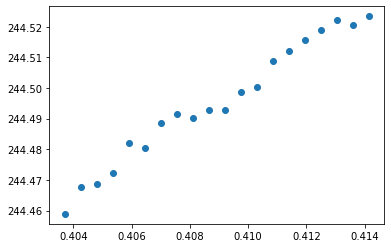

In [27]:
def save_array(path: str, filename: str, array: np.ndarray, message:str=''):
    s = os.path.join(path, filename)
    
    if (isinstance(array, np.ndarray)):
        print(f'Saving Numpy array file: {s}')
        np.save(s, array)
    elif (isinstance(array, nib.Nifti1Image)):
        print(f'Saving Nifti array file: {s}')
        nib.save(array, s)
    else:
        print('Array type supported in save_array, add it!?')


print(spectralopen_th0.shape)  # E.g. (9, 32, 512, 512)

open_mean_th0 = np.mean(spectralopen_th0, axis=1)
openmean_th1 = np.mean(spectralopen_th1, axis=1)

for i in range(0, 1):
    # openmean_th0.shape[0] was causing trouble...
    print(i, open_mean_th0.shape, open_mean_th0.shape[0])  # E.g. 0 (9, 512, 512) 9
    open_mean_th0[i, :, :] = open_mean_th0[i, :, :]/exp_time[i]
    openmean_th1[i, :, :] = openmean_th1[i, :, :]/exp_time[i]

for i in range(0, 1):
    # spectralprojs_th0.shape[0] was causing trouble...
    spectral_projs_th0[i, :, :, :] = spectral_projs_th0[i, :, :, :]/exp_time[i]
    spectralprojs_th1[i, :, :, :] = spectralprojs_th1[i, :, :, :]/exp_time[i]

# global_detector_shift_y = -0.31872500000000004
gReconVoxels = (600, 600, 600)     # number of voxels              (vx)
gReconSize = (15, 15, 15)          # total size of the image       (mm)
# for th0 in range(0,openmean_th0.shape[0]):
for th in range(0, 1):
    mean = 0.25*(np.mean(open_mean_th0[th, 0:255, 0:255]) + np.mean(open_mean_th0[th, 0:255, 257:512]) + np.mean(
        open_mean_th0[th, 257:512, 0:255]) + np.mean(open_mean_th0[th, 257:512, 257:512]))
    print(f'th = {th}, mean = {mean}')  # E.g. 36895.64768079413
    regression_out = np.zeros((3, 512, 512))
    DAC_values = np.zeros((512, 512))
    for i in trange(0, open_mean_th0.shape[1]):
        for j in range(0, open_mean_th0.shape[2]):
            yvalues = open_mean_th0[:, i, j]
            regressions, res, _, _, _ = np.polyfit(th0_list, yvalues, 2, full=True)
            regression_out[:, i, j] = regressions
            DAC = solve_for_y(regressions, mean)[1]
            if (DAC > th0_list[th]*2) or (DAC < th0_list[th]/2):
                DAC = th0_list[th]
            DAC_values[i, j] = DAC
    
    fit_array = spectral_projs_th0.reshape(spectral_projs_th0.shape[0], -1)

    print('Fitting polynomials... ~1 minute')
    regressions, res, _, _, _ = np.polyfit(th0_list, fit_array, 2, full=True)

    print('Calculating DACs...')
    calc_dacs = np.repeat(DAC_values[np.newaxis, :, :], spectral_projs_th0.shape[1], axis=0).flatten()

    print('Calculating projection data...')
    proj_data_flat = (regressions[0, :]*calc_dacs**2) + \
        (regressions[1, :]*calc_dacs**1) + regressions[2, :]
    projection_data = proj_data_flat.reshape(
        spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    save_array(results_folder, 'Projections_th0_' + str(th0_list[th])+'_keV.npy', projection_data)
    
    mean = (np.mean(projection_data[:, :, 0:10]) + np.mean(projection_data[:, :, 503:513]))/2
    ofc = -np.log(projection_data/mean)
    save_array(results_folder, 'projs_th0_'+str(th0_list[th])+'OFC_interp.npy', ofc)

    print('Doing median filter on OFC data...')
    ofc_mf = filereader.median_filter_projection_set(ofc, 5)
    diff_mf = np.abs(ofc-ofc_mf)
    meanmap = np.mean(diff_mf, axis=0)
    stdmap = np.std(diff_mf, axis=0)
    badmap = np.ones((512, 512))
    half = np.int32(badmap.shape[0]/2)
    badmap[half-2:half+1] = 0
    badmap[:, half-2:half+1] = 0
    badmap[meanmap > 0.2] = 0
    badmap[stdmap > 0.05] = 0
    ofc_bpc = filereader.apply_badmap_to_projections(ofc, badmap)
    ofc_bpc_mf = filereader.median_filter_projection_set(ofc_bpc, 3)
    if th == 0:
        print(f'th = {th}, finding optimal offset')
        global_detector_shift_y = find_optimal_offset(
            spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stageoffset=0, searchrange=10)
        print(f'global_detector_shift_y = {global_detector_shift_y} (pixels ?)')
        
        ni_img = nib.Nifti1Image(ofc_bpc_mf, np.eye(4))
        save_array(results_folder, 'Proj_th0_'+str(th0_list[th])+'OFC_BPC_MF.nii', ni_img)
    
    print('Doing recon finally!')
    img_th0 = recon_scan(ofc_bpc, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    
    ni_img = nib.Nifti1Image(img_th0, np.eye(4))
    save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC.nii', ni_img)

    img_th0 = recon_scan(ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th0, np.eye(4))
    save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC_MF.nii', ni_img)


In [ ]:
for th1 in range(0, openmean_th1.shape[0]):
    mean = 0.25*(np.mean(openmean_th1[th1, 0:255, 0:255]) + np.mean(openmean_th1[th1, 0:255, 257:512]) + np.mean(
        openmean_th1[th1, 257:512, 0:255]) + np.mean(openmean_th1[th1, 257:512, 257:512]))
    print(mean)
    regression_out = np.zeros((3, 512, 512))
    DACvalues = np.zeros((512, 512))
    for i in range(0, openmean_th1.shape[1]):
        for j in range(0, openmean_th1.shape[2]):
            yvalues = openmean_th1[:, i, j]
            regressions, res, _, _, _ = np.polyfit(th1_list, yvalues, 2, full=True)
            regression_out[:, i, j] = regressions
            DAC = solve_for_y(regressions, mean)[1]
            if (DAC > th1_list[th1]*2) or (DAC < th1_list[th1]/2):
                DAC = th1_list[th1]
            DACvalues[i, j] = DAC
    fitarray = spectralprojs_th1.reshape(spectralprojs_th1.shape[0], -1)
    regressions, res, _, _, _ = np.polyfit(th1_list, fitarray, 2, full=True)
    calcdacs = np.repeat(DACvalues[np.newaxis, :, :], spectralprojs_th1.shape[1], axis=0).flatten()

    projdataflat = (regressions[0, :]*calcdacs**2) + \
        (regressions[1, :]*calcdacs**1) + regressions[2, :]
    projectiondata = projdataflat.reshape(
        spectralprojs_th1.shape[1], spectralprojs_th1.shape[2], spectralprojs_th1.shape[3])
    np.save(os.path.join(results_folder, 'Projections_th1_'
            + str(th1_list[th1])+'_keV.npy'), projectiondata)

    mean = (np.mean(projectiondata[:, :, 0:10]) + np.mean(projectiondata[:, :, 503:513]))/2
    ofc = -np.log(projectiondata/mean)
    ni_img = nib.Nifti1Image(ofc, np.eye(4))
    np.save(os.path.join(results_folder, 'projs_th1_'+str(th1_list[th1])+'OFC_interp.npy'), ofc)
    ofc_mf = filereader.median_filter_projection_set(ofc, 5)
    diff_mf = np.abs(ofc-ofc_mf)
    meanmap = np.mean(diff_mf, axis=0)
    stdmap = np.std(diff_mf, axis=0)
    badmap = np.ones((512, 512))
    half = np.int32(badmap.shape[0]/2)
    badmap[half-2:half+1] = 0
    badmap[:, half-2:half+1] = 0
    badmap[meanmap > 0.2] = 0
    badmap[stdmap > 0.05] = 0
    ofc_bpc = filereader.apply_badmap_to_projections(ofc, badmap)
    ofc_bpc_mf = filereader.median_filter_projection_set(ofc_bpc, 3)
    img_th1 = recon_scan(ofc_bpc, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th1, np.eye(4))
    nib.save(ni_img, os.path.join(results_folder, 'Recon_th1_'+str(th1_list[th1])+'OFC_BPC.nii'))
    img_th1 = recon_scan(ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th1, np.eye(4))
    nib.save(ni_img, os.path.join(results_folder, 'Recon_th1_'+str(th1_list[th1])+'OFC_BPC_MF.nii'))


In [ ]:

openmeansingle_th0 = np.mean(open_mean_th0, axis=(1, 2))
openmeansingle_th1 = np.mean(openmean_th1, axis=(1, 2))
plt.scatter(th0_list, openmeansingle_th0, label="th0")
plt.scatter(th1_list, openmeansingle_th1, label="th1")


In [ ]:
# global_detector_shift_y = 0.37565
global_detector_shift_y = -0.31872500000000004

hyperlist = [500]
lambdalist = [0.010]
for hyper in hyperlist:
    for tvlambda in lambdalist:
        # hyper=2.0e3
        tviter = 100
        # tvlambda=0.005
        img_th0 = recon_scan_fista(ofc_2_mf.astype(np.float32), angles, z_offset, detector_x_offsets,
                                   detector_y_offsets, global_detector_shift_y, hyper, tviter, tvlambda)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_fista_mf_'
                 + str(tviter) + '_' + str(hyper)+'_'+str(tvlambda) + '.nii'))


In [ ]:
drive = 'f:\\'
basefolder = os.path.join(drive, 'jasper', 'data', '20220603_RealTumor')
basejsonfile = os.path.join(basefolder, 'scan_settings.json')

if os.path.exists(basejsonfile):
    f = open(basejsonfile)
    dashboard = json.load(f)
    for i in dashboard['thresholdscan']:
        scanfolder = os.path.join(basefolder, dashboard['thresholdscan'][i]['projectionsfolder'])
        scanjson = os.path.join(scanfolder, dashboard['thresholdscan'][i]['projections_json'])
        detector_x_offsets, detector_y_offsets = get_detector_offsets(scanjson)
        angles = get_proj_angles(scanjson)
        z_offset = get_samplestage_z_offset(scanjson)
        projs_th0 = get_OFC_projections(scanjson, th0=True, UseOrig=False, ApplyLog=True)

        # projectionsCorr = tomopy.prep.stripe.remove_all_stripe(projs_th0, snr=3, la_size=61, sm_size=21, dim=1, ncore=60, nchunk=None)
        projectionsCorr = tomopy.prep.stripe.remove_stripe_fw(
            projs_th0, level=None, wname='db5', sigma=0.2, pad=True, ncore=60, nchunk=None)
        # global_detector_shift_y = find_optimal_offset(projs_th0, angles, detector_x_offsets, detector_y_offsets, z_offset)
        global_detector_shift_y = 0.1915
        gReconVoxels = (600, 512, 512)             # number of voxels              (vx)
        gReconSize = (15, 12.8, 12.8)          # total size of the image       (mm)

        img_th0 = recon_scan(projs_th0, angles, z_offset, detector_x_offsets,
                             detector_y_offsets, global_detector_shift_y)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_'+str(0)+'_th0_orig.nii'))
        # imgfdk = tomopy.misc.corr.remove_ring(img_th0, center_x=None, center_y=None, thresh=1000.0, thresh_max=5000.0, thresh_min=10.0, theta_min=50, rwidth=10, int_mode='WRAP', ncore=60, nchunk=None, out=None)
        # ni_img = nib.Nifti1Image(imgfdk, np.eye(4))
        # nib.save(ni_img,  os.path.join(basefolder,'recon_'+str(0)+'_th0_corr_pre_post.nii'))
        img_th0 = recon_scan(projectionsCorr, angles, z_offset, detector_x_offsets,
                             detector_y_offsets, global_detector_shift_y)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_'+str(0)+'_th0_corr2.nii'))
